# Text-to-SQL Evaluation Analysis

Visualization and analysis of LLM performance on text-to-SQL generation.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

RESULTS_PATH = Path("../results/evaluation_results.json")

with open(RESULTS_PATH) as f:
    data = json.load(f)

df = pd.DataFrame(data["results"])
summary = data["summary"]
print(f"Loaded {len(df)} results from {data['metadata']['num_models']} models x {data['metadata']['num_queries']} queries")
df.head()

Loaded 72 results from 4 models x 18 queries


,query_id,concept_tag,nl_question,model,generated_sql,raw_output,execution_success,exact_match,fuzzy_match,row_count_match,row_overlap_pct,result_match,failure_mode,gt_row_count,gen_row_count,missing_count,extra_count,latency_s,error_detail
0,ba01,basic,List all customers from Brazil.,qwen2.5-coder-7b,SELECT FirstName || ' ' || LastName AS FullNam...,SELECT FirstName || ' ' || LastName AS FullNam...,True,False,False,True,0.0,False,wrong_values,5.0,5.0,5.0,5.0,2.02,NaN
1,ba02,basic,How many tracks are in each genre? Show the ge...,qwen2.5-coder-7b,"SELECT T2.Name, COUNT(*) AS TrackCount FROM TR...","SELECT T2.Name, COUNT(*) AS TrackCount FROM TR...",True,True,True,True,100.0,True,NaN,25.0,25.0,0.0,0.0,1.66,NaN
2,ba03,basic,Find the total number of invoices and the over...,qwen2.5-coder-7b,"SELECT COUNT(*) , SUM(Total) FROM INVOICE","SELECT COUNT(*) , SUM(Total) FROM INVOICE",True,True,True,True,100.0,True,NaN,1.0,1.0,0.0,0.0,1.17,NaN
3,in01,intermediate,Find all albums that have more than 20 tracks.,qwen2.5-coder-7b,SELECT Title FROM ALBUM WHERE AlbumId IN (SELE...,SELECT Title FROM ALBUM WHERE AlbumId IN (SELE...,True,False,False,True,0.0,False,wrong_values,17.0,17.0,17.0,17.0,1.16,NaN
4,in02,intermediate,Which customers have placed more than 5 invoic...,qwen2.5-coder-7b,SELECT c.FirstName || ' ' || c.LastName AS Cus...,SELECT c.FirstName || ' ' || c.LastName AS Cus...,True,True,True,True,100.0,True,NaN,59.0,59.0,0.0,0.0,1.77,NaN


## Overall Accuracy by Model

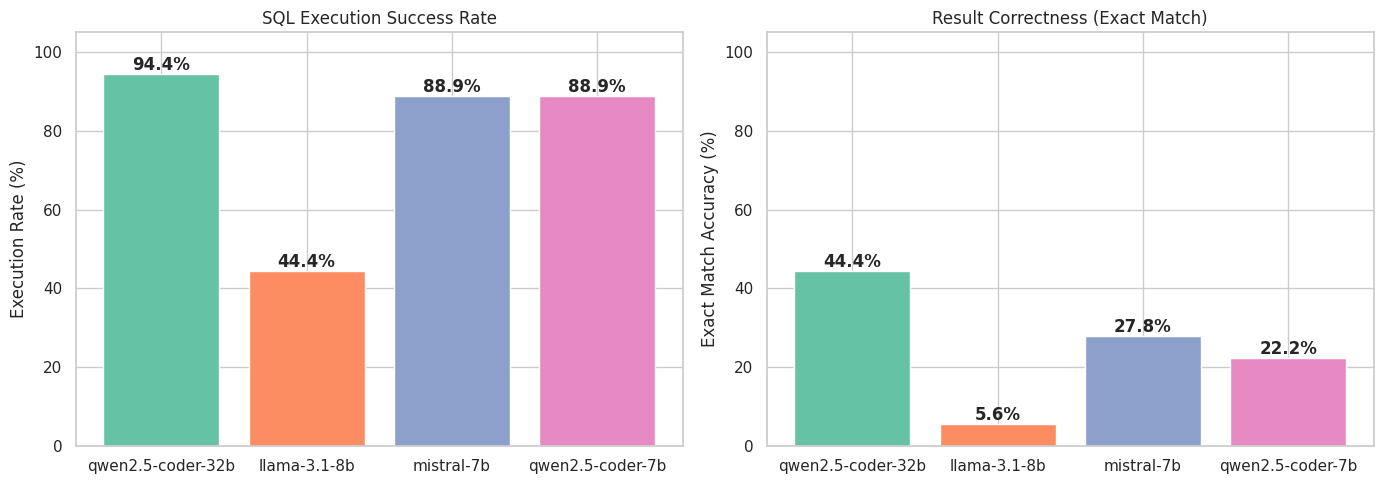

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = list(summary.keys())
exec_rates = [summary[m]["execution_rate"] for m in models]
accuracies = [summary[m]["accuracy"] for m in models]

colors = sns.color_palette("Set2", len(models))

# Execution Rate
bars1 = axes[0].bar(models, exec_rates, color=colors)
axes[0].set_ylabel("Execution Rate (%)")
axes[0].set_title("SQL Execution Success Rate")
axes[0].set_ylim(0, 105)
for bar, val in zip(bars1, exec_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{val:.1f}%", ha="center", fontweight="bold")

# Exact Match Accuracy
bars2 = axes[1].bar(models, accuracies, color=colors)
axes[1].set_ylabel("Exact Match Accuracy (%)")
axes[1].set_title("Result Correctness (Exact Match)")
axes[1].set_ylim(0, 105)
for bar, val in zip(bars2, accuracies):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{val:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.savefig("../results/overall_accuracy.png", dpi=150, bbox_inches="tight")
plt.show()

## Accuracy by SQL Concept

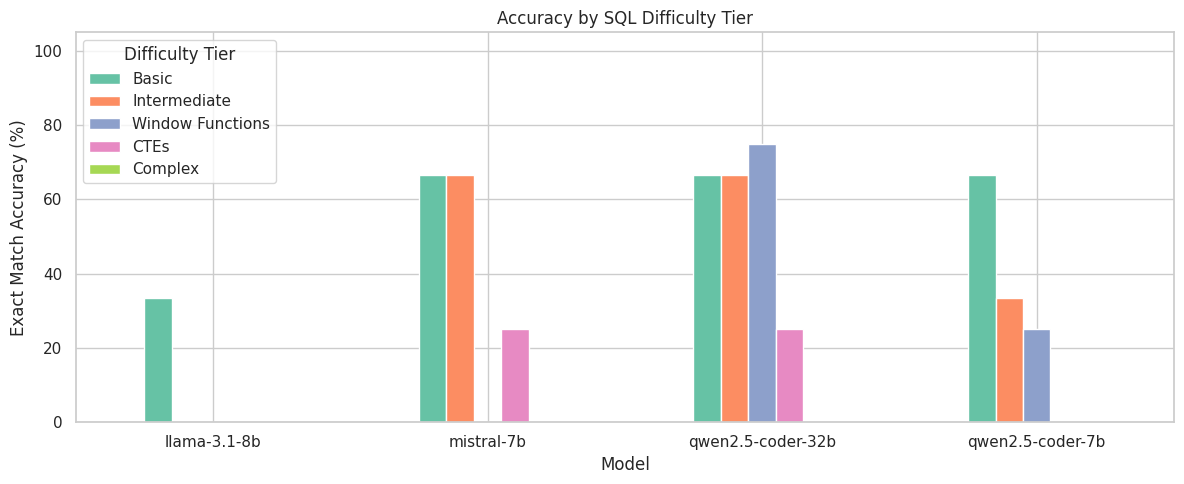

In [3]:
concept_data = []
for model in models:
    for concept, label in [("basic", "Basic"),
                           ("intermediate", "Intermediate"),
                           ("window_function", "Window Functions"),
                           ("cte", "CTEs"),
                           ("complex_combination", "Complex")]:
        bc = summary[model]["by_concept"].get(concept, {"exact_match": 0, "total": 0})
        acc = bc["exact_match"] / bc["total"] * 100 if bc["total"] else 0
        concept_data.append({"Model": model, "Concept": label, "Accuracy": acc})

concept_df = pd.DataFrame(concept_data)

tier_order = ["Basic", "Intermediate", "Window Functions", "CTEs", "Complex"]
concept_df["Concept"] = pd.Categorical(concept_df["Concept"], categories=tier_order, ordered=True)

fig, ax = plt.subplots(figsize=(12, 5))
concept_df.pivot(index="Model", columns="Concept", values="Accuracy").plot(
    kind="bar", ax=ax, color=sns.color_palette("Set2", 5)
)
ax.set_ylabel("Exact Match Accuracy (%)")
ax.set_title("Accuracy by SQL Difficulty Tier")
ax.set_ylim(0, 105)
ax.legend(title="Difficulty Tier")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../results/accuracy_by_concept.png", dpi=150, bbox_inches="tight")
plt.show()

## Failure Mode Analysis

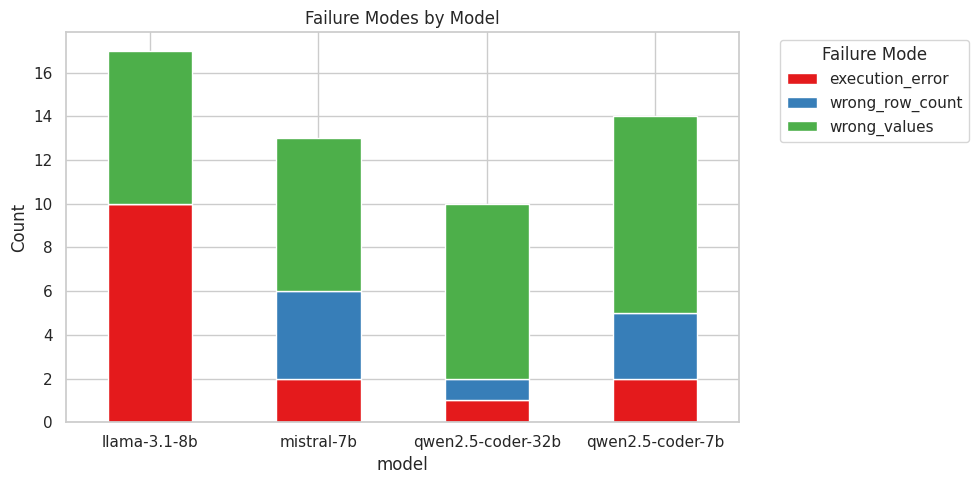

In [4]:
failure_df = df[df["failure_mode"].notna()].copy()

if not failure_df.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    ct = pd.crosstab(failure_df["model"], failure_df["failure_mode"])
    ct.plot(kind="bar", stacked=True, ax=ax, color=sns.color_palette("Set1", ct.shape[1]))
    ax.set_ylabel("Count")
    ax.set_title("Failure Modes by Model")
    ax.legend(title="Failure Mode", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("../results/failure_modes.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No failures to analyze!")

## Latency Comparison

/tmp/ipykernel_46903/4267412735.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=latency_df, x="model", y="latency_s", palette="Set2", ax=ax)


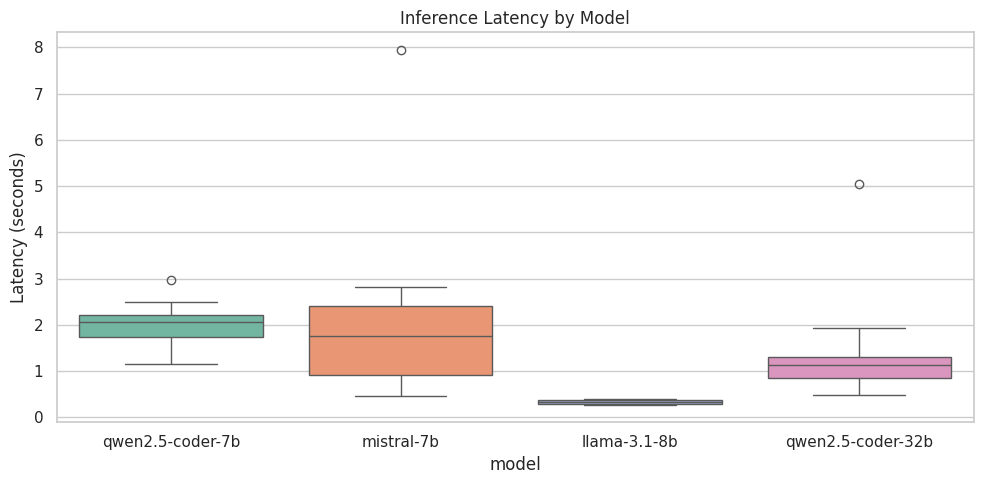

In [5]:
latency_df = df[df["latency_s"].notna()].copy()

if not latency_df.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=latency_df, x="model", y="latency_s", palette="Set2", ax=ax)
    ax.set_ylabel("Latency (seconds)")
    ax.set_title("Inference Latency by Model")
    plt.tight_layout()
    plt.savefig("../results/latency.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No latency data available yet. Run the evaluation first.")

## Detailed Results Table

In [6]:
display_cols = ["query_id", "concept_tag", "model", "execution_success", "result_match", "failure_mode", "latency_s"]
available_cols = [c for c in display_cols if c in df.columns]
pivot = df[available_cols].copy()
pivot.style.map(
    lambda v: "background-color: #d4edda" if v is True else ("background-color: #f8d7da" if v is False else ""),
    subset=[c for c in ["execution_success", "result_match"] if c in available_cols]
)

,query_id,concept_tag,model,execution_success,result_match,failure_mode,latency_s
0,ba01,basic,qwen2.5-coder-7b,True,False,wrong_values,2.020000
1,ba02,basic,qwen2.5-coder-7b,True,True,nan,1.660000
2,ba03,basic,qwen2.5-coder-7b,True,True,nan,1.170000
3,in01,intermediate,qwen2.5-coder-7b,True,False,wrong_values,1.160000
4,in02,intermediate,qwen2.5-coder-7b,True,True,nan,1.770000
5,in03,intermediate,qwen2.5-coder-7b,True,False,wrong_values,1.740000
6,wf01,window_function,qwen2.5-coder-7b,False,False,execution_error,2.160000
7,wf02,window_function,qwen2.5-coder-7b,True,False,wrong_values,2.490000
8,wf03,window_function,qwen2.5-coder-7b,True,True,nan,2.000000
9,wf04,window_function,qwen2.5-coder-7b,True,False,wrong_values,1.980000


## Key Takeaways

In [7]:
# Build a compact summary of each model's per-tier accuracy
from IPython.display import Markdown

tier_labels = {"basic": "Basic", "intermediate": "Intermediate",
               "window_function": "Window", "cte": "CTE",
               "complex_combination": "Complex"}
tier_order = list(tier_labels.keys())

rows = []
for model in sorted(summary.keys()):
    s = summary[model]
    tier_accs = []
    for t in tier_order:
        bc = s["by_concept"].get(t, {"exact_match": 0, "total": 0})
        acc = bc["exact_match"] / bc["total"] * 100 if bc["total"] else 0
        tier_accs.append(acc)
    rows.append({
        "model": model,
        "overall": s["accuracy"],
        "exec_rate": s["execution_rate"],
        "tiers": tier_accs,
    })

# Sort by overall accuracy descending
rows.sort(key=lambda r: r["overall"], reverse=True)

# Print summary
lines = ["### Difficulty Curve\n"]
for r in rows:
    arrow = " → ".join(f"{a:.0f}%" for a in r["tiers"])
    lines.append(f"**{r['model']}** ({r['overall']:.1f}% overall): {arrow}")

lines.append("\n### Observations\n")

# Best model
best = rows[0]
lines.append(f"1. **Scale drives accuracy.** The largest model ({best['model']}) achieves "
             f"{best['overall']:.1f}% exact match — nearly {best['overall']/rows[-1]['overall']:.0f}x "
             f"the smallest model's {rows[-1]['overall']:.1f}%.")

# Complex tier
complex_scores = [r["tiers"][-1] for r in rows]
lines.append(f"2. **Complex queries remain unsolved.** No model exceeds {max(complex_scores):.0f}% "
             f"on the hardest tier (CTEs + window functions), suggesting multi-step SQL reasoning "
             f"is a persistent weakness for open-source models at this scale.")

# Execution vs accuracy gap
best_exec = max(r["exec_rate"] for r in rows)
best_acc = max(r["overall"] for r in rows)
lines.append(f"3. **Execution ≠ correctness.** The best execution rate is {best_exec:.0f}% but "
             f"the best exact-match accuracy is only {best_acc:.0f}%. Models often produce "
             f"syntactically valid SQL that returns wrong results — row counts may match "
             f"but values differ.")

# Dominant failure mode
all_failures = {}
for model in summary:
    for fm, count in summary[model].get("failure_modes", {}).items():
        all_failures[fm] = all_failures.get(fm, 0) + count
if all_failures:
    top_fm = max(all_failures, key=all_failures.get)
    lines.append(f"4. **Most common failure: `{top_fm}`** ({all_failures[top_fm]} of "
                 f"{sum(all_failures.values())} total failures). "
                 f"Models frequently produce the right schema and row count but incorrect values, "
                 f"indicating logic errors rather than syntax errors.")

Markdown("\n".join(lines))

### Difficulty Curve

**qwen2.5-coder-32b** (44.4% overall): 67% → 67% → 75% → 25% → 0%
**mistral-7b** (27.8% overall): 67% → 67% → 0% → 25% → 0%
**qwen2.5-coder-7b** (22.2% overall): 67% → 33% → 25% → 0% → 0%
**llama-3.1-8b** (5.6% overall): 33% → 0% → 0% → 0% → 0%

### Observations

1. **Scale drives accuracy.** The largest model (qwen2.5-coder-32b) achieves 44.4% exact match — nearly 8x the smallest model's 5.6%.
2. **Complex queries remain unsolved.** No model exceeds 0% on the hardest tier (CTEs + window functions), suggesting multi-step SQL reasoning is a persistent weakness for open-source models at this scale.
3. **Execution ≠ correctness.** The best execution rate is 94% but the best exact-match accuracy is only 44%. Models often produce syntactically valid SQL that returns wrong results — row counts may match but values differ.
4. **Most common failure: `wrong_values`** (31 of 54 total failures). Models frequently produce the right schema and row count but incorrect values, indicating logic errors rather than syntax errors.